In [1]:
from pykalman import KalmanFilter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
sns.set_style('white')

In [2]:
filename = "../data/Binance_ETHUSDT_minute.csv"
data = pd.read_csv(filename, header=1, nrows = 10000, index_col=1, dtype={'unix': "Int64", 'open':np.float32, 'high':np.float32, 'low':np.float32, 'close':np.float32, 'Volume ETH':np.float32, 'Volume USDT':np.float32})

data = data.iloc[::-1]
data = data.iloc[2000:2100,:]
data.describe()

,unix,open,high,low,close,Volume ETH,Volume USDT,tradecount
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000
mean,1.613389e+12,1781.362061,1782.988403,1780.162476,1781.513794,559.282410,9.967660e+05,590.390000
std,1.740690e+06,8.559385,8.575565,8.521655,8.390030,348.591980,6.218729e+05,316.428424
min,1.613386e+12,1760.349976,1763.270020,1760.219971,1760.439941,180.943970,3.221698e+05,265.000000
25%,1.613388e+12,1776.227509,1777.295044,1774.925018,1776.387543,345.687569,6.180214e+05,402.500000
50%,1.613389e+12,1782.394958,1783.494995,1781.250000,1782.359985,459.841843,8.185425e+05,493.000000
75%,1.613390e+12,1787.842529,1789.595032,1786.129974,1787.835022,687.810165,1.223658e+06,611.500000
max,1.613392e+12,1794.569946,1796.280029,1793.630005,1794.560059,2229.435059,3.978020e+06,1913.000000


In [3]:
window_short_halflife = 2
window_long_halflife = 5
SD = 0.005

'''
kf_short = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = data['close'][0],
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.1)

kf_short = kf_short.em(data['close'], n_iter=2)

mean_short, cov = kf_short.filter(data['close'])
mean_short, std = mean_short.squeeze(), np.std(cov.squeeze())

kf_long = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = data['close'][0],
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.1)

kf_long = kf_long.em(data['close'], n_iter=5)

mean_long, cov = kf_long.filter(data['close'])
mean_long, std = mean_long.squeeze(), np.std(cov.squeeze())

plt.figure(figsize=(20,8))
plt.plot(data['close'] , 'b', lw=1)
plt.plot(mean_short, 'r', lw=1)
plt.plot(mean_long, 'y', lw=1)
# plt.plot(-np.sqrt(cov.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
#plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.legend(['ETH', 'MEAN'])
plt.xlabel('Day')
plt.ylabel('Value')
'''
data['short_window'] = data['close'].ewm(halflife=window_short_halflife).mean()
data['long_window'] = data['close'].ewm(halflife=window_long_halflife).mean()

#data['short_window'] = mean_long
#data['long_window'] = mean_short

#data['short_window'] = data['short_window'].ewm(halflife=1).mean()
#data['long_window'] = data['long_window'].ewm(halflife=1).mean()
data.head()

,unix,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount,short_window,long_window
date,,,,,,,,,,,
2021-02-15 10:47:00,1613386020000,ETH/USDT,1764.849976,1765.930054,1761.959961,1762.489990,469.513428,828009.0000,487,1762.489990,1762.489990
2021-02-15 10:48:00,1613386080000,ETH/USDT,1762.489990,1764.500000,1761.910034,1764.489990,264.485901,466269.6875,369,1763.661563,1763.559194
2021-02-15 10:49:00,1613386140000,ETH/USDT,1764.489990,1764.489990,1760.439941,1760.439941,316.947052,558585.0000,389,1762.201905,1762.372449
2021-02-15 10:50:00,1613386200000,ETH/USDT,1760.349976,1763.270020,1760.219971,1762.989990,212.088669,373778.0625,280,1762.509671,1762.560256
2021-02-15 10:51:00,1613386260000,ETH/USDT,1763.000000,1763.810059,1762.910034,1763.550049,206.417511,363941.5625,285,1762.879825,1762.816512


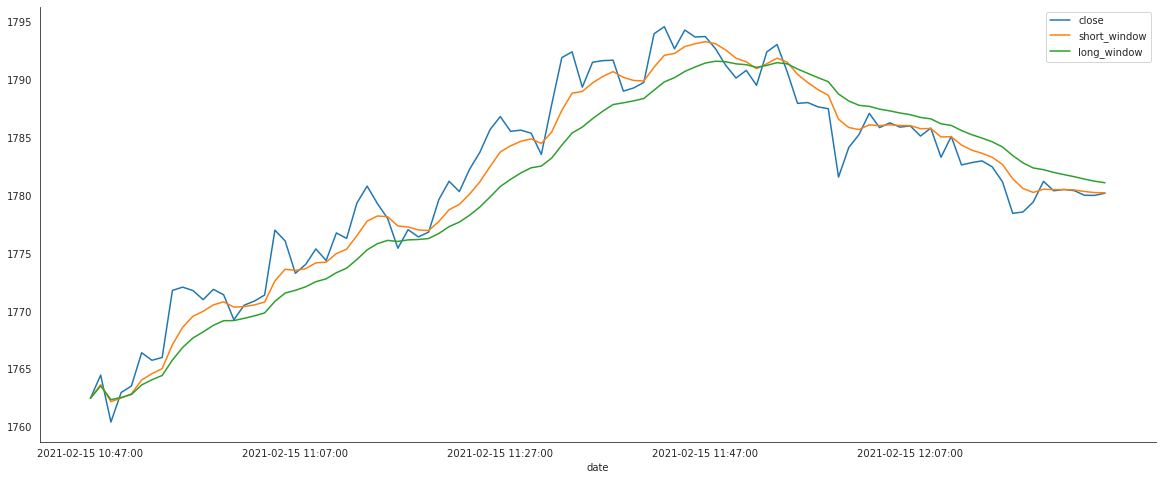

In [4]:
data[['close', 'short_window', 'long_window']].plot(grid=False, figsize=(20,8))
sns.despine()

In [5]:
data['s-l'] = data['short_window'] - data['long_window']
# data['s-l'].tail()

In [6]:
# data['Regime'] = np.where(data['s-l'] > data['long_window'] * SD, 1, -1)
data['Regime'] = np.where(data['s-l'] > 0, 1, -1)

x = data['Regime'].to_numpy()

y = np.zeros(data.shape[0])
for i in range(data.shape[0]-1):
    # Long Pos
    if x[i] < x[i+1]: 
        y[i+1] = 1
    # Short Pos
    elif x[i] > x[i+1]:
        y[i+1] = -1

data['Position'] = y

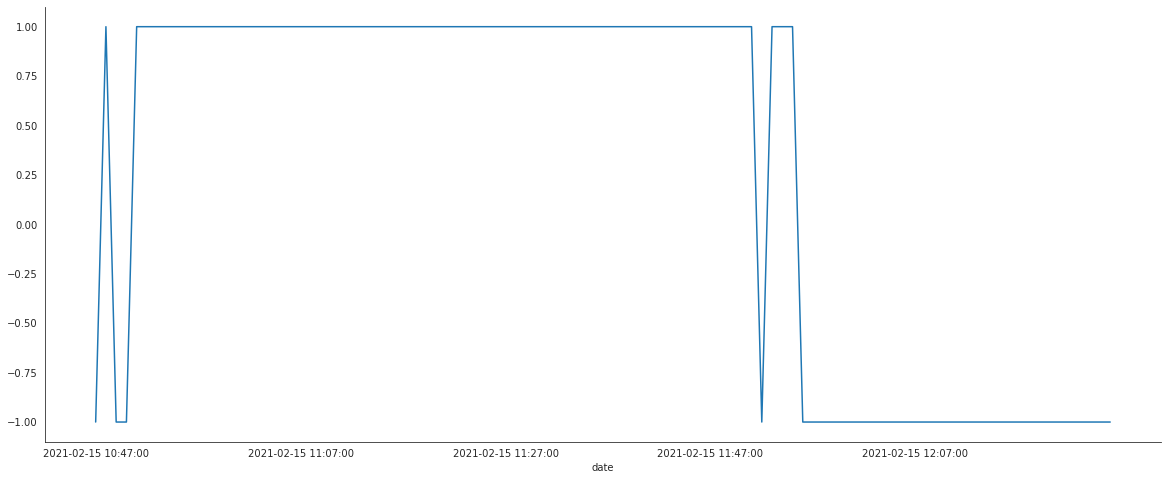

In [7]:
data['Regime'].plot(grid=False, lw=1.5, figsize=(20,8))
pylab.ylim((-1.1,1.1))
sns.despine()

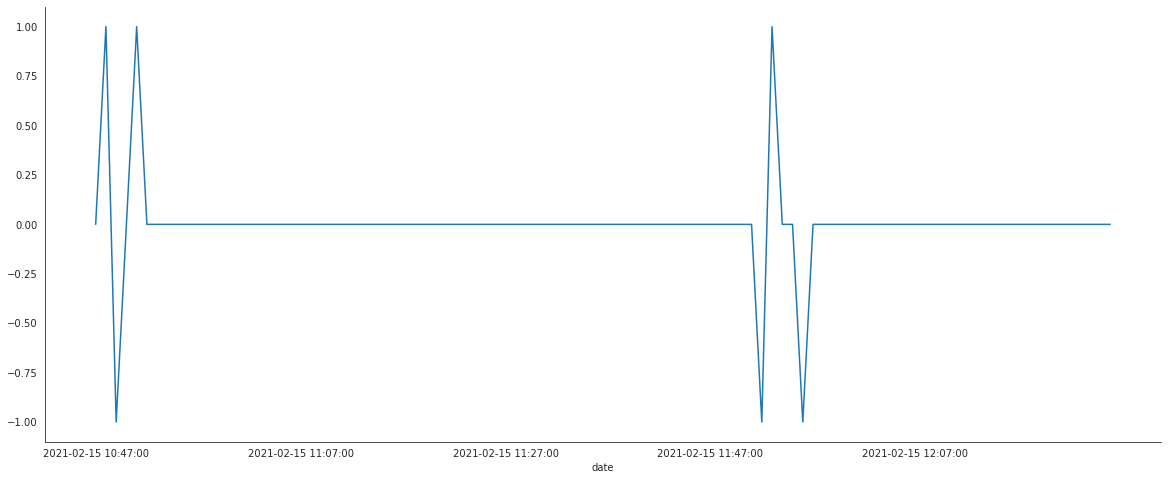

In [8]:
data['Position'].plot(grid=False, lw=1.5, figsize=(20,8))
pylab.ylim((-1.1,1.1))
sns.despine()

In [9]:
data['Market'] = np.log(data['close'] / data['close'].shift(1))
# data['Strategy'] = data['Position'] * data['close']
# data[['Market', 'Strategy', 'Regime']].tail()
current_position = 0
open_position_price = 0

income = np.zeros(data.shape[0])

for i in range(data.shape[0]):
    # No Change in Position
    if data['Position'][i] == 0: 
        continue
    # switch to long position
    if data['Position'][i] == 1:
        # close short position
        if current_position == -1:
            income[i] = (open_position_price - data['close'][i]) / open_position_price
        # open long position
        open_position_price = data['close'][i]
        current_position = 1
    # switch to short position
    else:
         # close long position
        if current_position == 1:
            income[i] = (data['close'][i] - open_position_price) / open_position_price
        # open long position
        open_position_price = data['close'][i]
        current_position = -1
    # print(open_position_price)

# close the last position
if current_position == -1:
    income[data.shape[0] - 1] = (open_position_price - data['close'][data.shape[0] - 1]) / open_position_price
elif current_position == 1:
    income[data.shape[0] - 1] = (data['close'][data.shape[0] - 1] - open_position_price) / open_position_price
    
data['Strategy'] = income
# data[['Market', 'Strategy', 'Regime']].tail()

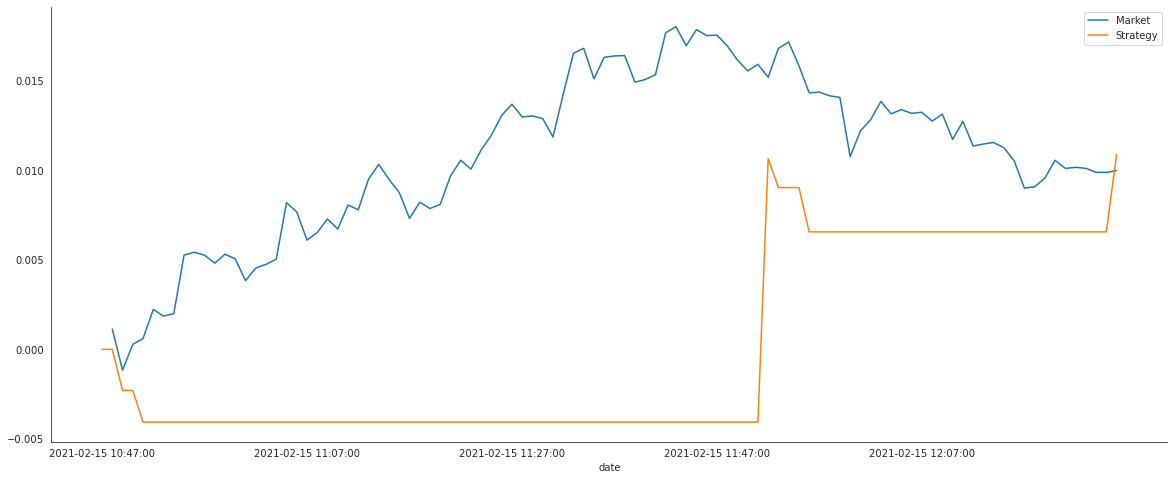

In [10]:
data[['Market', 'Strategy']].cumsum().plot(grid=False, figsize=(20,8))
sns.despine()